# ANN classification

Training model of type:
Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1, out_features=1, bias=True)
  (3): Sigmoid()
)


Crossvalidation fold: 1/4

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	0.695956	2.3979821e-05
		2000	0.69188607	2.9290256e-06
		3000	0.67919976	5.738989e-05
		4000	0.6066513	0.00011562912
		5000	0.5588082	5.567544e-05
		6000	0.53606325	3.0242649e-05
		7000	0.5231006	2.016784e-05
		8000	0.5147775	1.3431135e-05
		9000	0.5090207	8.782175e-06
		10000	0.5048351	6.965937e-06
		Final loss:
		10000	0.5048351	6.965937e-06

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	0.6465885	8.728994e-05
		2000	0.58031136	0.00010239287
		3000	0.537164	5.4590193e-05
		4000	0.5158122	2.9696736e-05
		5000	0.5042811	1.7847467e-05
		6000	0.49742082	1.1323561e-05
		7000	0.49304622	7.797382e-06
		8000	0.49011934	4.9252826e-06
		9000	0.48808786	3.7856646e-06
		10000	0.48663288	2.2047036e-06
		Final loss:
		10000	0.48663288	2.2047036

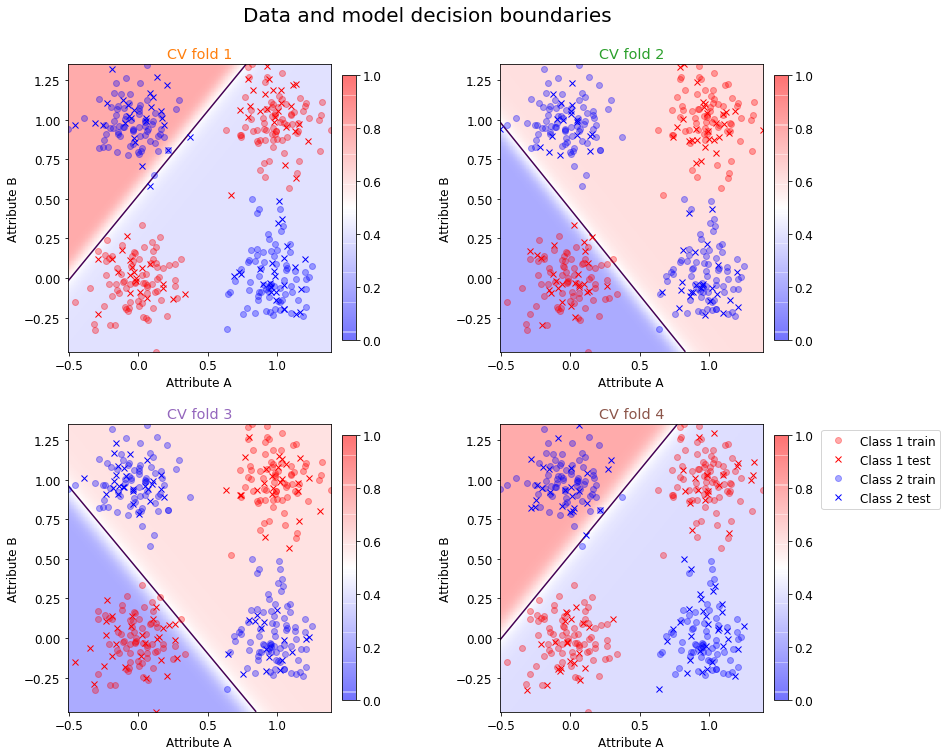

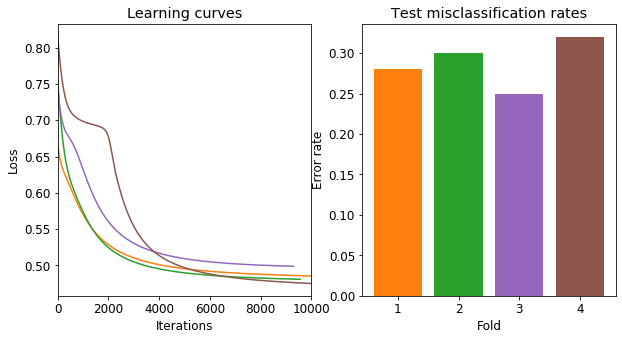

Diagram of best neural net in last fold:


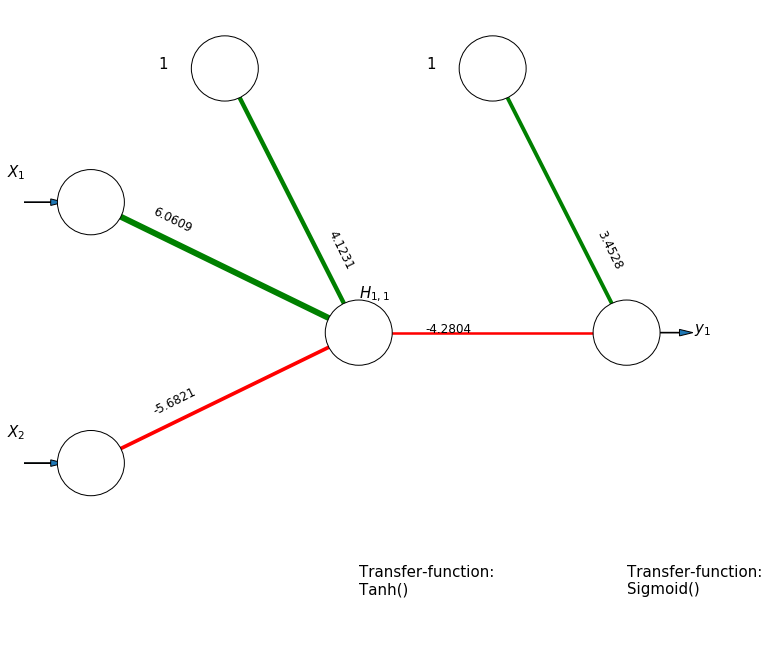


Generalization error/average error rate: 28.75%
Ran exercise 8.2.2.


In [4]:
# exercise 8.2.2
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from sklearn import model_selection
from toolbox_02450 import train_neural_net, draw_neural_net, visualize_decision_boundary
import torch
plt.rcParams.update({'font.size': 12})

# read XOR DATA from matlab datafile
mat_data = loadmat('./data/xor.mat')
X = mat_data['X']
y = mat_data['y']

attributeNames = [name[0] for name in mat_data['attributeNames'].squeeze()]
classNames = [name[0] for name in mat_data['classNames'].squeeze()]
N, M = X.shape
C = len(classNames)

# K-fold CrossValidation (4 folds here to speed up this example)
K = 4
CV = model_selection.KFold(K,shuffle=True)

# Setup figure for display of the decision boundary for the several crossvalidation folds.
decision_boundaries = plt.figure(1, figsize=(10,10))
# Determine a size of a plot grid that fits visualizations for the chosen number
# of cross-validation splits, if K=4, this is simply a 2-by-2 grid.
subplot_size_1 = int(np.floor(np.sqrt(K))) 
subplot_size_2 = int(np.ceil(K/subplot_size_1))
# Set overall title for all of the subplots
plt.suptitle('Data and model decision boundaries', fontsize=20)
# Change spacing of subplots
plt.subplots_adjust(left=0, bottom=0, right=1, top=.9, wspace=.5, hspace=0.25)

# Setup figure for display of learning curves and error rates in fold
summaries, summaries_axes = plt.subplots(1, 2, figsize=(10,5))
# Make a list for storing assigned color of learning curve for up to K=10
color_list = ['tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink',
              'tab:gray', 'tab:olive', 'tab:cyan', 'tab:red', 'tab:blue']

# Define the model structure
n_hidden_units = 1 # number of hidden units in the signle hidden layer
# The lambda-syntax defines an anonymous function, which is used here to 
# make it easy to make new networks within each cross validation fold
model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, n_hidden_units), #M features to H hiden units
                    # 1st transfer function, either Tanh or ReLU:
                    #torch.nn.ReLU(), 
                    torch.nn.Tanh(),   
                    torch.nn.Linear(n_hidden_units, 1), # H hidden units to 1 output neuron
                    torch.nn.Sigmoid() # final tranfer function
                    )
# Since we're training a neural network for binary classification, we use a 
# binary cross entropy loss (see the help(train_neural_net) for more on
# the loss_fn input to the function)
loss_fn = torch.nn.BCELoss()
# Train for a maximum of 10000 steps, or until convergence (see help for the 
# function train_neural_net() for more on the tolerance/convergence))
max_iter = 10000
print('Training model of type:\n{}\n'.format(str(model())))

# Do cross-validation:
errors = [] # make a list for storing generalizaition error in each loop
# Loop over each cross-validation split. The CV.split-method returns the 
# indices to be used for training and testing in each split, and calling 
# the enumerate-method with this simply returns this indices along with 
# a counter k:
for k, (train_index, test_index) in enumerate(CV.split(X,y)): 
    print('\nCrossvalidation fold: {0}/{1}'.format(k+1,K))    
    
    # Extract training and test set for current CV fold, 
    # and convert them to PyTorch tensors
    X_train = torch.tensor(X[train_index,:], dtype=torch.float)
    y_train = torch.tensor(y[train_index], dtype=torch.float)
    X_test = torch.tensor(X[test_index,:], dtype=torch.float)
    y_test = torch.tensor(y[test_index], dtype=torch.uint8)
    
    # Go to the file 'toolbox_02450.py' in the Tools sub-folder of the toolbox
    # and see how the network is trained (search for 'def train_neural_net',
    # which is the place the function below is defined)
    net, final_loss, learning_curve = train_neural_net(model,
                                                       loss_fn,
                                                       X=X_train,
                                                       y=y_train,
                                                       n_replicates=3,
                                                       max_iter=max_iter)
    
    print('\n\tBest loss: {}\n'.format(final_loss))
    
    # Determine estimated class labels for test set
    y_sigmoid = net(X_test) # activation of final note, i.e. prediction of network
    y_test_est = y_sigmoid > .5 # threshold output of sigmoidal function
    
    # Determine errors and error rate
    e = (y_test_est != y_test)
    error_rate = (sum(e).type(torch.float)/len(y_test)).data.numpy()
    errors.append(error_rate) # store error rate for current CV fold 
    
    # Make a subplot for current cross validation fold that displays the 
    # decision boundary over the original data, "background color" corresponds
    # to the output of the sigmoidal transfer function (i.e. before threshold),
    # white areas are areas of uncertainty, and a deaper red/blue means 
    # that the network "is more sure" of a given class.
    plt.figure(decision_boundaries.number)
    plt.subplot(subplot_size_1,subplot_size_2,k+1)
    plt.title('CV fold {0}'.format(k+1),color=color_list[k])
    predict = lambda x: net(torch.tensor(x, dtype=torch.float)).data.numpy()
    visualize_decision_boundary(predict, X, y, # provide data, along with function for prediction
                                attributeNames, classNames, # provide information on attribute and class names
                                train=train_index, test=test_index, # provide information on partioning
                                show_legend=k==(K-1)) # only display legend for last plot
    
    # Display the learning curve for the best net in the current fold
    h, = summaries_axes[0].plot(learning_curve, color=color_list[k])
    h.set_label('CV fold {0}'.format(k+1))
    summaries_axes[0].set_xlabel('Iterations')
    summaries_axes[0].set_xlim((0, max_iter))
    summaries_axes[0].set_ylabel('Loss')
    summaries_axes[0].set_title('Learning curves')
    
# Display the error rate across folds
summaries_axes[1].bar(np.arange(1, K+1), np.squeeze(np.asarray(errors)), color=color_list)
summaries_axes[1].set_xlabel('Fold');
summaries_axes[1].set_xticks(np.arange(1, K+1))
summaries_axes[1].set_ylabel('Error rate');
summaries_axes[1].set_title('Test misclassification rates')
    
# Show the plots
plt.show(decision_boundaries.number)
plt.show(summaries.number)

# Display a diagram of the best network in last fold
print('Diagram of best neural net in last fold:')
weights = [net[i].weight.data.numpy().T for i in [0,2]]
biases = [net[i].bias.data.numpy() for i in [0,2]]
tf =  [str(net[i]) for i in [1,3]]
draw_neural_net(weights, biases, tf)

# Print the average classification error rate
print('\nGeneralization error/average error rate: {0}%'.format(round(100*np.mean(errors),4)))

print('Ran exercise 8.2.2.')

Training model of type:

Sequential(
  (0): Linear(in_features=11, out_features=2, bias=True)
  (1): Tanh()
  (2): Linear(in_features=2, out_features=1, bias=True)
  (3): Sigmoid()
)


Crossvalidation fold: 1/3

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.07173237	0.0009546583
		2000	0.039306622	0.00036011054
		3000	0.030051928	0.0002267986
		4000	0.024653183	0.00017835104
		5000	0.0202093	0.00021350702
		6000	0.017677546	8.597278e-05
		7000	0.01662156	4.6951773e-05
		8000	0.01598787	2.9591052e-05
		9000	0.015625492	1.7642109e-05
		Final loss:
		9032	0.015616768	5.3672426e-07

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.09513386	0.0012043135
		2000	0.044384114	0.0004845619
		3000	0.030875735	0.000280322
		4000	0.024669092	0.00018170803
		5000	0.02050428	0.00015994677
		6000	0.018252444	8.428544e-05
		7000	0.017157715	4.6895813e-05
		8000	0.016531104	2.9745363e-05
		9000	0.016107643	2.231751e-05
		10000	0.015780332	1.605262e-05
		Final loss:
		10000	0.015780332	1.605262e-05

	

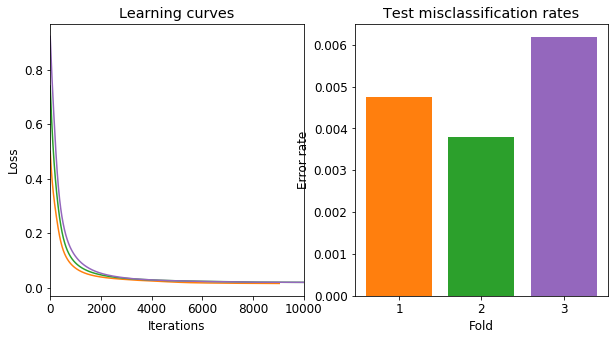

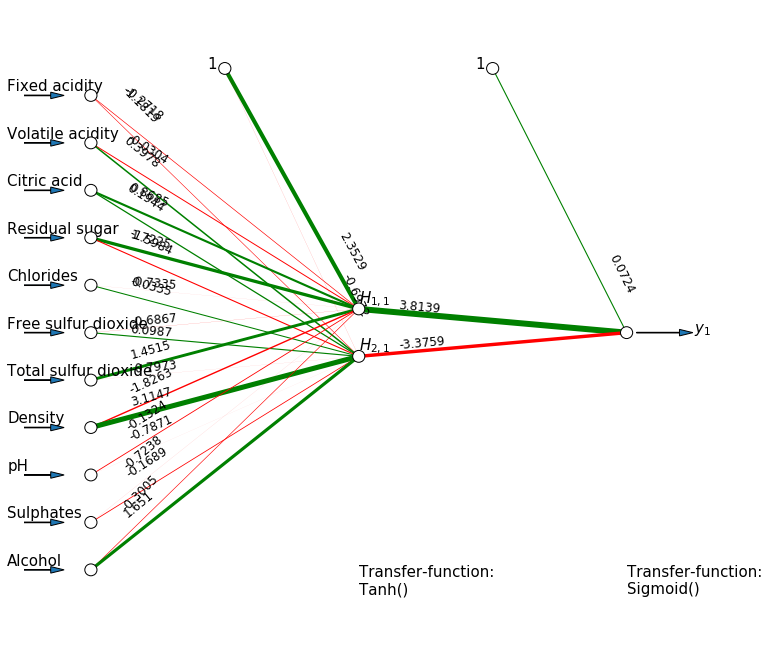


Generalization error/average error rate: 0.4918%
Ran Exercise 8.2.5


In [5]:
# exercise 8.2.5
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import torch
from sklearn import model_selection
from toolbox_02450 import train_neural_net, draw_neural_net
from scipy import stats

# Load Matlab data file and extract variables of interest
mat_data = loadmat('./data/wine2.mat')
attributeNames = [name[0] for name in mat_data['attributeNames'][0]]
X = mat_data['X']
y = mat_data['y']

#Downsample: X = X[1:20,:] y = y[1:20,:]
N, M = X.shape
C = 2

# Normalize data
X = stats.zscore(X);

# Parameters for neural network classifier
n_hidden_units = 2     # number of hidden units
n_replicates = 2        # number of networks trained in each k-fold
max_iter = 10000         # stop criterion 2 (max epochs in training)

# K-fold crossvalidation
K = 3                   # only five folds to speed up this example
CV = model_selection.KFold(K, shuffle=True)
# Make figure for holding summaries (errors and learning curves)
summaries, summaries_axes = plt.subplots(1,2, figsize=(10,5))
# Make a list for storing assigned color of learning curve for up to K=10
color_list = ['tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink',
              'tab:gray', 'tab:olive', 'tab:cyan', 'tab:red', 'tab:blue']

# Define the model, see also Exercise 8.2.2-script for more information.
model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, n_hidden_units), #M features to H hiden units
                    torch.nn.Tanh(),   # 1st transfer function,
                    torch.nn.Linear(n_hidden_units, 1), # H hidden units to 1 output neuron
                    torch.nn.Sigmoid() # final tranfer function
                    )
loss_fn = torch.nn.BCELoss()

print('Training model of type:\n\n{}\n'.format(str(model())))
errors = [] # make a list for storing generalizaition error in each loop
for k, (train_index, test_index) in enumerate(CV.split(X,y)): 
    print('\nCrossvalidation fold: {0}/{1}'.format(k+1,K))    
    
    # Extract training and test set for current CV fold, convert to tensors
    X_train = torch.tensor(X[train_index,:], dtype=torch.float)
    y_train = torch.tensor(y[train_index], dtype=torch.float)
    X_test = torch.tensor(X[test_index,:], dtype=torch.float)
    y_test = torch.tensor(y[test_index], dtype=torch.uint8)
    
    # Train the net on training data
    net, final_loss, learning_curve = train_neural_net(model,
                                                       loss_fn,
                                                       X=X_train,
                                                       y=y_train,
                                                       n_replicates=n_replicates,
                                                       max_iter=max_iter)
    
    print('\n\tBest loss: {}\n'.format(final_loss))
    
    # Determine estimated class labels for test set
    y_sigmoid = net(X_test)
    y_test_est = y_sigmoid>.5
    
    # Determine errors and errors
    e = y_test_est != y_test
    error_rate = (sum(e).type(torch.float)/len(y_test)).data.numpy()
    errors.append(error_rate) # store error rate for current CV fold 
    
    # Display the learning curve for the best net in the current fold
    h, = summaries_axes[0].plot(learning_curve, color=color_list[k])
    h.set_label('CV fold {0}'.format(k+1))
    summaries_axes[0].set_xlabel('Iterations')
    summaries_axes[0].set_xlim((0, max_iter))
    summaries_axes[0].set_ylabel('Loss')
    summaries_axes[0].set_title('Learning curves')
    
# Display the error rate across folds
summaries_axes[1].bar(np.arange(1, K+1), np.squeeze(np.asarray(errors)), color=color_list)
summaries_axes[1].set_xlabel('Fold');
summaries_axes[1].set_xticks(np.arange(1, K+1))
summaries_axes[1].set_ylabel('Error rate');
summaries_axes[1].set_title('Test misclassification rates')

print('Diagram of best neural net in last fold:')
weights = [net[i].weight.data.numpy().T for i in [0,2]]
biases = [net[i].bias.data.numpy() for i in [0,2]]
tf =  [str(net[i]) for i in [1,3]]
draw_neural_net(weights, biases, tf, attribute_names=attributeNames)

# Print the average classification error rate
print('\nGeneralization error/average error rate: {0}%'.format(round(100*np.mean(errors),4)))

print('Ran Exercise 8.2.5')

# ANN regression

Training model of type:

Sequential(
  (0): Linear(in_features=9, out_features=2, bias=True)
  (1): Tanh()
  (2): Linear(in_features=2, out_features=1, bias=True)
)


Crossvalidation fold: 1/3

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	47.556152	0.0010993343
		2000	15.771771	0.0011493072
		3000	4.654606	0.001256127
		4000	1.5474814	0.0008260502
		5000	0.9443778	0.000220413
		6000	0.830709	0.00010711357
		7000	0.73297256	0.00015505141
		8000	0.6117815	0.00018537111
		9000	0.52394086	0.0001217107
		10000	0.47563386	7.7188844e-05
		Final loss:
		10000	0.47563386	7.7188844e-05

	Best loss: 0.4756338596343994


Crossvalidation fold: 2/3

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	38.680817	0.001368743
		2000	10.429284	0.0013423014
		3000	2.6615944	0.0012970974
		4000	1.0284786	0.00053046294
		5000	0.77176356	0.00010108613
		6000	0.7251497	5.7451936e-05
		7000	0.6734995	9.256233e-05
		8000	0.6039799	0.00012028434
		9000	0.53790694	0.000104592255
		10000	0.4922493	7.409932e-05
		Fina

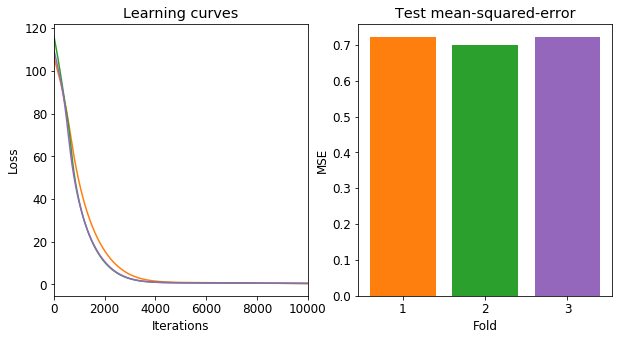

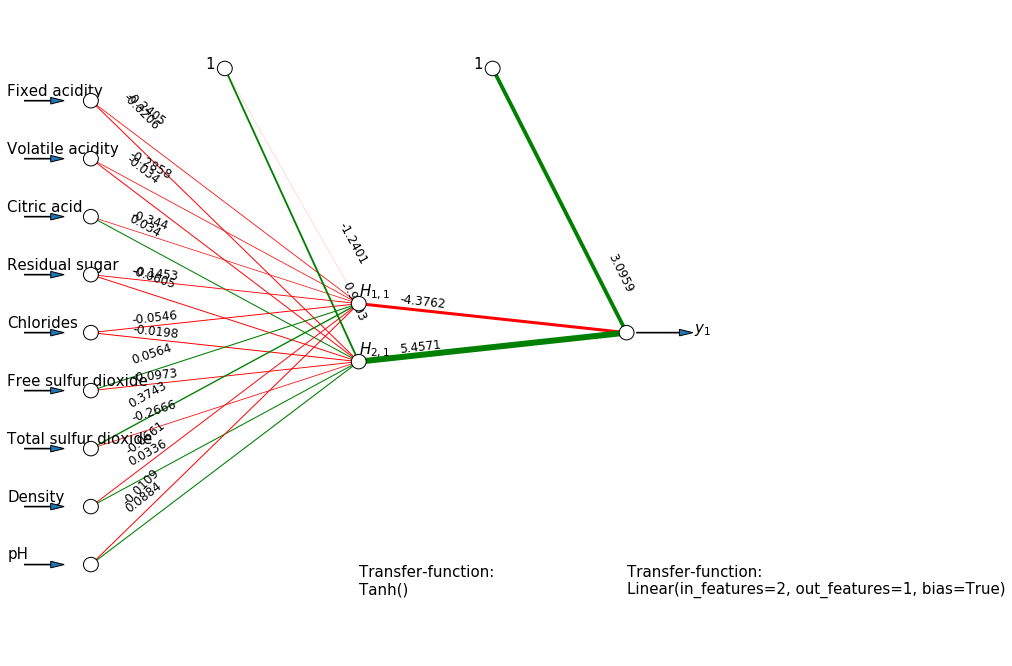


Estimated generalization error, RMSE: 0.8450999855995178


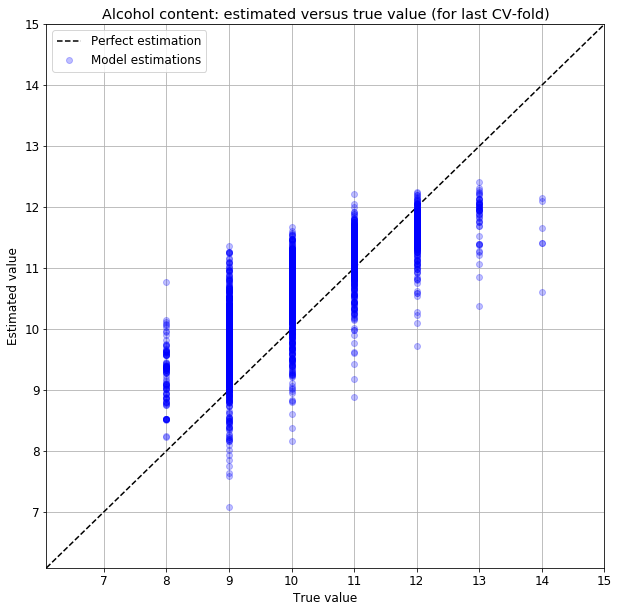

Ran Exercise 8.2.5


In [6]:
# exercise 8.2.6
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import torch
from sklearn import model_selection
from toolbox_02450 import train_neural_net, draw_neural_net
from scipy import stats

# Load Matlab data file and extract variables of interest
mat_data = loadmat('./data/wine2.mat')
attributeNames = [name[0] for name in mat_data['attributeNames'][0]]
X = mat_data['X']
y = X[:,[10]]             # alcohol contents (target)
X = X[:,1:10]           # the rest of features
N, M = X.shape
C = 2

# Normalize data
X = stats.zscore(X);
                
## Normalize and compute PCA (change to True to experiment with PCA preprocessing)
do_pca_preprocessing = False
if do_pca_preprocessing:
    Y = stats.zscore(X,0);
    U,S,V = np.linalg.svd(Y,full_matrices=False)
    V = V.T
    #Components to be included as features
    k_pca = 3
    X = X @ V[:,0:k_pca]
    N, M = X.shape


# Parameters for neural network classifier
n_hidden_units = 2      # number of hidden units
n_replicates = 1        # number of networks trained in each k-fold
max_iter = 10000        # 

# K-fold crossvalidation
K = 3                   # only three folds to speed up this example
CV = model_selection.KFold(K, shuffle=True)

# Setup figure for display of learning curves and error rates in fold
summaries, summaries_axes = plt.subplots(1,2, figsize=(10,5))
# Make a list for storing assigned color of learning curve for up to K=10
color_list = ['tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink',
              'tab:gray', 'tab:olive', 'tab:cyan', 'tab:red', 'tab:blue']
# Define the model
model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, n_hidden_units), #M features to n_hidden_units
                    torch.nn.Tanh(),   # 1st transfer function,
                    torch.nn.Linear(n_hidden_units, 1), # n_hidden_units to 1 output neuron
                    # no final tranfer function, i.e. "linear output"
                    )
loss_fn = torch.nn.MSELoss() # notice how this is now a mean-squared-error loss

print('Training model of type:\n\n{}\n'.format(str(model())))
errors = [] # make a list for storing generalizaition error in each loop
for (k, (train_index, test_index)) in enumerate(CV.split(X,y)): 
    print('\nCrossvalidation fold: {0}/{1}'.format(k+1,K))    
    
    # Extract training and test set for current CV fold, convert to tensors
    X_train = torch.tensor(X[train_index,:], dtype=torch.float)
    y_train = torch.tensor(y[train_index], dtype=torch.float)
    X_test = torch.tensor(X[test_index,:], dtype=torch.float)
    y_test = torch.tensor(y[test_index], dtype=torch.uint8)
    
    # Train the net on training data
    net, final_loss, learning_curve = train_neural_net(model,
                                                       loss_fn,
                                                       X=X_train,
                                                       y=y_train,
                                                       n_replicates=n_replicates,
                                                       max_iter=max_iter)
    
    print('\n\tBest loss: {}\n'.format(final_loss))
    
    # Determine estimated class labels for test set
    y_test_est = net(X_test)
    
    # Determine errors and errors
    se = (y_test_est.float()-y_test.float())**2 # squared error
    mse = (sum(se).type(torch.float)/len(y_test)).data.numpy() #mean
    errors.append(mse) # store error rate for current CV fold 
    
    # Display the learning curve for the best net in the current fold
    h, = summaries_axes[0].plot(learning_curve, color=color_list[k])
    h.set_label('CV fold {0}'.format(k+1))
    summaries_axes[0].set_xlabel('Iterations')
    summaries_axes[0].set_xlim((0, max_iter))
    summaries_axes[0].set_ylabel('Loss')
    summaries_axes[0].set_title('Learning curves')

# Display the MSE across folds
summaries_axes[1].bar(np.arange(1, K+1), np.squeeze(np.asarray(errors)), color=color_list)
summaries_axes[1].set_xlabel('Fold');
summaries_axes[1].set_xticks(np.arange(1, K+1))
summaries_axes[1].set_ylabel('MSE');
summaries_axes[1].set_title('Test mean-squared-error')
    
print('Diagram of best neural net in last fold:')
weights = [net[i].weight.data.numpy().T for i in [0,2]]
biases = [net[i].bias.data.numpy() for i in [0,2]]
tf =  [str(net[i]) for i in [1,2]]
draw_neural_net(weights, biases, tf, attribute_names=attributeNames)

# Print the average classification error rate
print('\nEstimated generalization error, RMSE: {0}'.format(round(np.sqrt(np.mean(errors)), 4)))

# When dealing with regression outputs, a simple way of looking at the quality
# of predictions visually is by plotting the estimated value as a function of 
# the true/known value - these values should all be along a straight line "y=x", 
# and if the points are above the line, the model overestimates, whereas if the
# points are below the y=x line, then the model underestimates the value
plt.figure(figsize=(10,10));
y_est = y_test_est.data.numpy(); y_true = y_test.data.numpy();
axis_range = [np.min([y_est, y_true])-1,np.max([y_est, y_true])+1]
plt.plot(axis_range,axis_range,'k--')
plt.plot(y_true, y_est,'ob',alpha=.25)
plt.legend(['Perfect estimation','Model estimations'])
plt.title('Alcohol content: estimated versus true value (for last CV-fold)')
plt.ylim(axis_range); plt.xlim(axis_range)
plt.xlabel('True value')
plt.ylabel('Estimated value')
plt.grid()

plt.show()

print('Ran Exercise 8.2.5')